In [25]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('../processed data/combined_covariates_interpolated.csv')

df = df[['date', 'location', 'confirmed']]

matrix_df = df.pivot(index='date', columns='location', values='confirmed')
matrix_df.index = pd.to_datetime(matrix_df.index)

# Interpolate NaN values in cumulative data using linear method
matrix_df = matrix_df.interpolate(method='linear', axis=0)
matrix_df = matrix_df.bfill().ffill()  # Handle boundaries

# Convert cumulative cases to daily new cases
matrix_df = matrix_df.diff()

# Remove the first row (NaN after diff)
matrix_df = matrix_df.iloc[1:]


# Set first non-zero value to 0 for each location
# for column in matrix_df.columns:
#     # Find first non-zero value
#     first_nonzero_mask = (matrix_df[column] > 0)
#     if first_nonzero_mask.any():
#         first_nonzero_idx = first_nonzero_mask.idxmax()
#         # Set it to 0
#         matrix_df.loc[first_nonzero_idx, column] = 0

# Find consecutive zeros at the end for each location
consecutive_zeros = {}
for column in matrix_df.columns:
    series = matrix_df[column]
    zeros_from_end = 0
    for i in range(len(series) - 1, -1, -1):
        if series.iloc[i] == 0:
            zeros_from_end += 1
        else:
            break
    consecutive_zeros[column] = zeros_from_end

# Remove common zero rows from the end
min_zeros = min(consecutive_zeros.values())
if min_zeros > 0:
    matrix_df = matrix_df.iloc[:-min_zeros]

print("\nTotal number of NaN values:", matrix_df.isna().sum().sum())

# Save the processed data to CSV
output_path = '../../StemGNN/dataset/Covid_ours.csv'
matrix_df.to_csv(output_path, index=False)

# Split data using StemGNN style ratios
# Reference: train_length=7, valid_length=2, test_length=1
train_length = 7
valid_length = 2
test_length = 1

total_length = train_length + valid_length + test_length
train_ratio = train_length / total_length
valid_ratio = valid_length / total_length
test_ratio = test_length / total_length

print(f"Train ratio: {train_ratio:.3f}, Valid ratio: {valid_ratio:.3f}, Test ratio: {test_ratio:.3f}")

# Split the data
total_rows = len(matrix_df)
train_end = int(train_ratio * total_rows)
valid_end = int((train_ratio + valid_ratio) * total_rows)

train_df = matrix_df[:train_end]
valid_df = matrix_df[train_end:valid_end]
test_df = matrix_df[valid_end:]

print(f"Total rows: {total_rows}")
print(f"Train rows: {len(train_df)}")
print(f"Valid rows: {len(valid_df)}")
print(f"Test rows: {len(test_df)}")

# Save split datasets
train_df.to_csv('../../StemGNN/dataset/Covid_ours_train.csv', index=False)
valid_df.to_csv('../../StemGNN/dataset/Covid_ours_valid.csv', index=False)
test_df.to_csv('../../StemGNN/dataset/Covid_ours_test.csv', index=False)

print("Datasets saved successfully!")


Total number of NaN values: 0
Train ratio: 0.700, Valid ratio: 0.200, Test ratio: 0.100
Total rows: 877
Train rows: 613
Valid rows: 176
Test rows: 88
Datasets saved successfully!
Train ratio: 0.700, Valid ratio: 0.200, Test ratio: 0.100
Total rows: 877
Train rows: 613
Valid rows: 176
Test rows: 88
Datasets saved successfully!


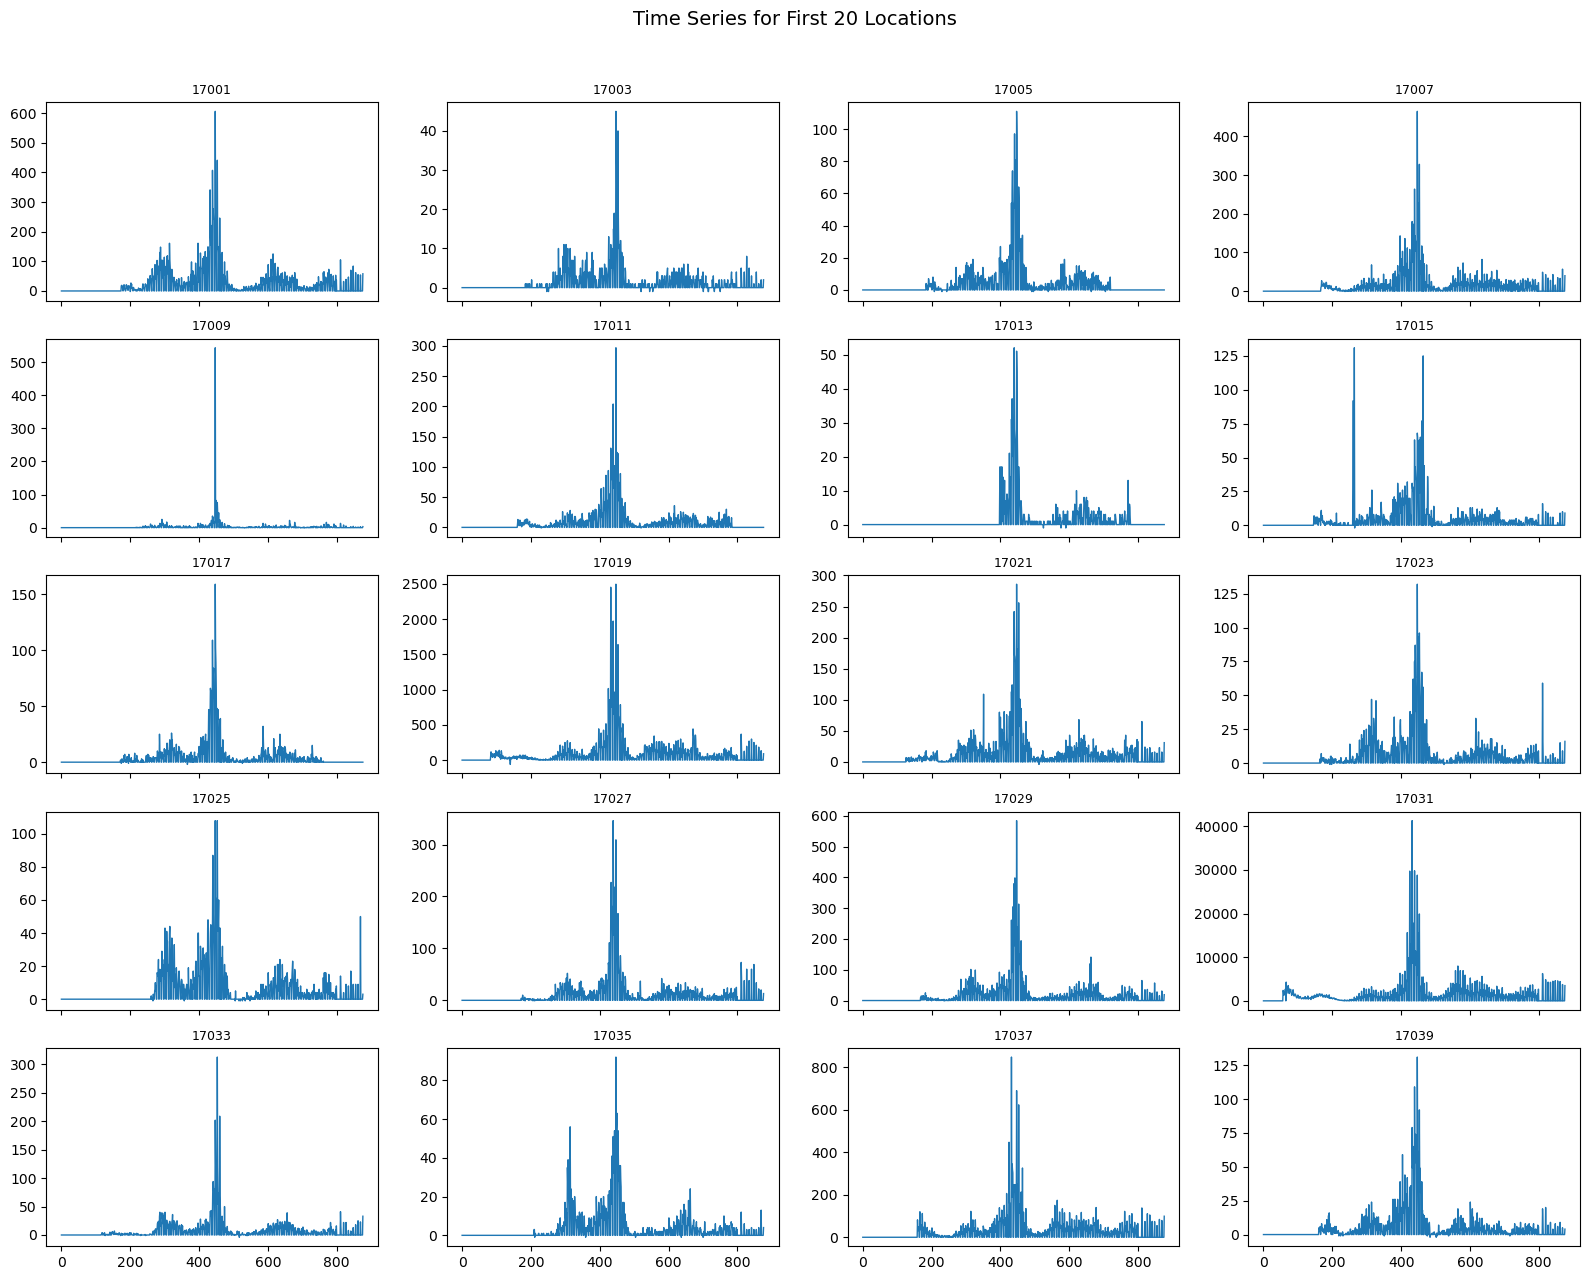

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import math

# ===== 1) Read CSV =====
path = '../../StemGNN/dataset/Covid_ours.csv'
df = pd.read_csv(path)

# Data is now pure numeric, no date column
# Take only first 20 locations
df = df.iloc[:, :20]

# ===== 2) Facet Plot =====
n_loc = df.shape[1]
cols = 4   # 4 subplots per row
rows = math.ceil(n_loc / cols)

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 2.5*rows), sharex=True)
axes = axes.ravel()

for i, col in enumerate(df.columns):
    ax = axes[i]
    ax.plot(df.index, df[col], linewidth=1)
    ax.set_title(col, fontsize=9)

# Hide extra subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.suptitle('Time Series for First 20 Locations', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()